In [1]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("Pdf File")
sc = SparkContext(conf = conf)

In [2]:
import io
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

In [3]:
import time
import re
import math
import glob

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

In [5]:
path = 'E:\PDFfileall'
global pathlen
pathlen=len(path)
files = [f for f in glob.glob(path + "**/*.pdf")]
#print(files)

In [6]:
global names
names=[]
global co
co=0

In [7]:
def convert_pdf_to_txt(path):
    global co
    print(co)
    co=co+1
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)
        

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    text = re.findall('[a-zA-Z][a-zA-Z]+',text)
    #print(text)
    return text

In [8]:
def read_files_from(file_list):
    termsDoc=[]
    for i in file_list:
        x=convert_pdf_to_txt(i)
        termsDoc.append([a.lower() for a in x])   
    return termsDoc 

def spark(files):
    n_parts = 2
    rdd1 = sc.parallelize(files, n_parts ) #distribute files among nodes
    ts=time.clock()
    list_of_pdf_strings = rdd1.mapPartitions(read_files_from).collect()
    ts=time.clock()-ts
    print(ts)
    return list_of_pdf_strings

In [9]:
"""type(list_of_pdf_strings)
for i in files:    
    names.append(i[pathlen+1:])"""

'type(list_of_pdf_strings)\nfor i in files:    \n    names.append(i[pathlen+1:])'

In [10]:
def FilterDoc(files):
    termsDoc=[]
    names=[]
    for i in files:
        x=convert_pdf_to_txt(i)
        #x = re.findall('[a-zA-Z]{2}[a-zA-z]*',x)
        termsDoc.append([a.lower() for a in x])
        names.append(i[pathlen+1:])
    return termsDoc, names

In [11]:
global sw
sw=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
tdoc=[]
termsDoc=[]
completeList=[]

In [12]:
global names
termsDoc,names=FilterDoc(files)
print("\n\nThe Pdfs available are:\n")
s=0
for i in names:
    print(s+1,") ",i)
    s=s+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


The Pdfs available are:

1 )  A Particle Swarm Optimization Approach for Training Artiﬁcial Neural Networks with Uncertain Data.pdf
2 )  A Survey of Particle Swarm Optimization Applications in Electric Power Systems .pdf
3 )  a-hybrid-algorithm-for-kmedoid-clustering-of-large-data-sets.pdf
4 )  Adapting Particle Swarm Optimization to Stock Markets.pdf
5 )  Adaptive Firefly Optimization Algorithm Based On Stochastic Inertia Weight .pdf
6 )  An Improved K-means Algorithm Using Modified Cosine Distance  Measure for Document Clustering Using Mahout with Hadoop .pdf
7 )  Analysis of Particle Swarm Optimization Algorithm .pdf
8 )  AnIntelligentParameterSelectionMethodforParticleSwarmOptimization Algorithm.pdf
9 )  Clustering large datasets using K‑means modified inter and intra clustering (KM‑I2C) in Hadoop.pdf
10 )  Continuous Clustering in Big Data Learning Analytics .pdf
11 )  Craz

In [13]:
def RemStopWords(termsDoc):
    global sw
    termsDoc1=termsDoc
    for i in range(len(names)):
        termsDoc[i]=[a for a in termsDoc[i] if a not in sw]
    return termsDoc,termsDoc1

In [14]:
termsDoc,termsDoc1=RemStopWords(termsDoc)
def CreatingList(termsDoc):
    global sw
    global completeList
    trial=[]
    #trial=ai+wm+dm
    #print(len(trial),len(ai))
    trial = [a for a in termsDoc]
    for i in trial:
        for j in i:
            if j not in sw:
                completeList.append(j)
    completeList=list(set(completeList))
CreatingList(termsDoc)


In [15]:
def BooleanMatrix(termsDoc1):
    global completeList
    lenOfDocs=[]
    for i in termsDoc1:
        lenOfDocs.append(len(i))
    l=-1
    bools=[]
    for k in termsDoc:
        temp=[]
        l=l+1
        for i in completeList:
            if(i in k):
                x=k.count(i)
                temp.append(x/lenOfDocs[l])
            else:
                temp.append(0)
        bools.append(temp)
    mat=[completeList]
    for i in bools:
        mat.append(i)
    return mat

In [16]:
mat=BooleanMatrix(termsDoc1)
def idfVector(mat):
    global completeList
    idf=[]
    for i in range(len(completeList)):
        c=0
        for j in range(len(names)):
            #print(mat[j+1][i])
            if(mat[j+1][i]>0):
                c=c+1
        if(c!=0):
            idfx=math.log((1+3)/c)
        else:
            idfx=0
        idf.append(idfx)
    return idf

In [17]:
print(mat)

[['implementation', 'threshold', 'validation', 'er', 'last', 'nearly', 'magnitude', 'lincoln', 'jxpabs', 'jeyakumar', 'proposition', 'bharat', 'scalability', 'icccn', 'christopher', 'option', 'nigam', 'int', 'unavoid', 'tlvwl', 'problems', 'bayesian', 'identifiers', 'ct', 'wrapper', 'rosendo', 'comprises', 'hyuck', 'dense', 'bor', 'august', 'notion', 'iadcc', 'martens', 'introduciton', 'july', 'universality', 'helpful', 'delhi', 'embedded', 'george', 'drastically', 'ple', 'disappointment', 'subcluster', 'heavy', 'ut', 'dkj', 'corrugated', 'claimed', 'explo', 'probability', 'distribute', 'glover', 'cogeneration', 'distant', 'sudden', 'originally', 'practical', 'haphazard', 'tor', 'dissimilar', 'cells', 'bal', 'production', 'stutz', 'kassabalidis', 'qi', 'naka', 'definitive', 'asst', 'things', 'noises', 'decoding', 'ieeetransactions', 'design', 'coordination', 'read', 'temperate', 'hyperbolic', 'optrcal', 'krusienski', 'predominantly', 'deregu', 'transformed', 'singularity', 'era', 'cope

In [18]:
words=mat[0]
mat=mat[1:]
M=pd.DataFrame(mat,columns=words)
#print(M)
X = M.iloc[:,:].values
#print(X)

kmeans = KMeans(n_clusters =4,init = 'k-means++',max_iter=100000,n_init=10)
y_kmeans = kmeans.fit_predict(X)

print(y_kmeans)

pd.DataFrame(names,y_kmeans)
for i in names:
    print(i)

In [19]:
X=pd.DataFrame(mat)

In [20]:
print(len(X.columns))

9301


In [21]:
import pickle

In [22]:

def save_training_data(X):
    pickle_out=open("x.pickle","wb")
    pickle.dump(X,pickle_out)
    pickle_out.close()
save_training_data(X)

In [23]:
def load_data():
    pickle_in=open("x.pickle","rb")
    X=pickle.load(pickle_in)
    return X
X=load_data()

In [24]:
global k
k=[]
arr="2,3,4,5,6,7,8,9,10,11".split(',')

In [25]:
print(arr)

['2', '3', '4', '5', '6', '7', '8', '9', '10', '11']


In [26]:
def multiple_kmeans(arr):
    termsDoc=[]
    global distortions
    distortions=[]
    for i in arr:
        global k
        #x=convert_pdf_to_txt(i)
        #termsDoc.append([a.lower() for a in x])  
        kmeans = KMeans(n_clusters =int(i),init = 'k-means++',max_iter=10000,n_init=10)
        kmeans.fit(X)
        y_kmeans = kmeans.fit_predict(X)
        #k.append(y_kmeans)
        #distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        #distortions.append(kmeans.inertia_)
        label = kmeans.labels_
        distortions.append(silhouette_score(X, label, metric='euclidean'))
    return distortions

n_parts = 3
rdd = sc.parallelize(arr, n_parts ) #distribute files among nodes
ts=time.clock()
Y = rdd.mapPartitions(multiple_kmeans).collect()
ts=time.clock()-ts
print(ts)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


24.80622630000002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [27]:
print(Y)

[0.6616730048208493, 0.14979060309719452, 0.12797250396535004, 0.12160947054198949, 0.11503157275470492, 0.09543802537740434, 0.09715540130716449, 0.06756414126856358, 0.05820731573325885, 0.05200606067582237]


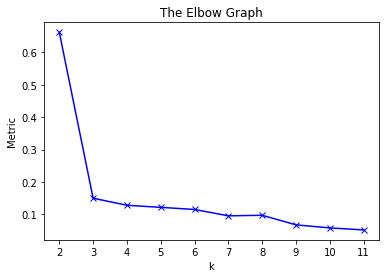

In [28]:
plt.plot(arr, Y, 'bx-')
plt.xlabel('k')
plt.ylabel('Metric')
plt.title('The Elbow Graph')
plt.show()

In [29]:
K=int(input("Enter the value of K: "))
kmeans = KMeans(n_clusters =K
                ,init = 'k-means++',max_iter=100000,n_init=10)
y_kmeans = kmeans.fit_predict(X)

Enter the value of K: 3


In [30]:
print(y_kmeans)

[0 0 2 0 0 2 0 0 2 2 0 0 0 1 0 0 0 2 2 0 0 0 0 0 2 2 2 2 0 2 2 0 0 0 0 1 2
 0 2]


In [31]:
Result=pd.DataFrame(names,y_kmeans)

In [32]:
Result.sort_index()

,0
0,A Particle Swarm Optimization Approach for Tra...
0,Partition based clustering of large datasets u...
0,"Particle Swarm Optimization Developments, Appl..."
0,"Particle Swarm Optimization Developments, Appl..."
0,Particle Swarm Optimization and Firefly Algori...
0,Mathematical Modelling and Applications of Par...
0,Intelligent Firefly Optimization System .pdf
0,Improving a Particle Swarm Optimization Algori...
0,Improved Optimization Technique using Hybrid A...
0,Hybrid Firefly Algorithm .pdf


X.info()

from pyspark.sql import SQLContext
spark = SQLContext(sc)

data=spark.createDataFrame(X)

data_rdd=data.rdd

data_rdd.cache()

data

clusters = KMeans.train(data_rdd, 4, maxIterations=100, initializationMode="random")